In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

import sys
sys.path.append('../../tool_code/function/')

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


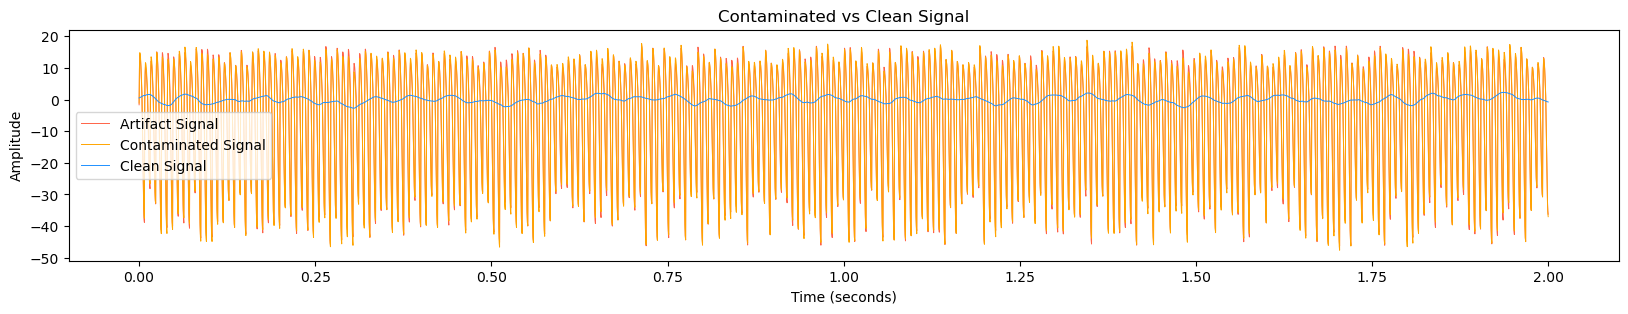

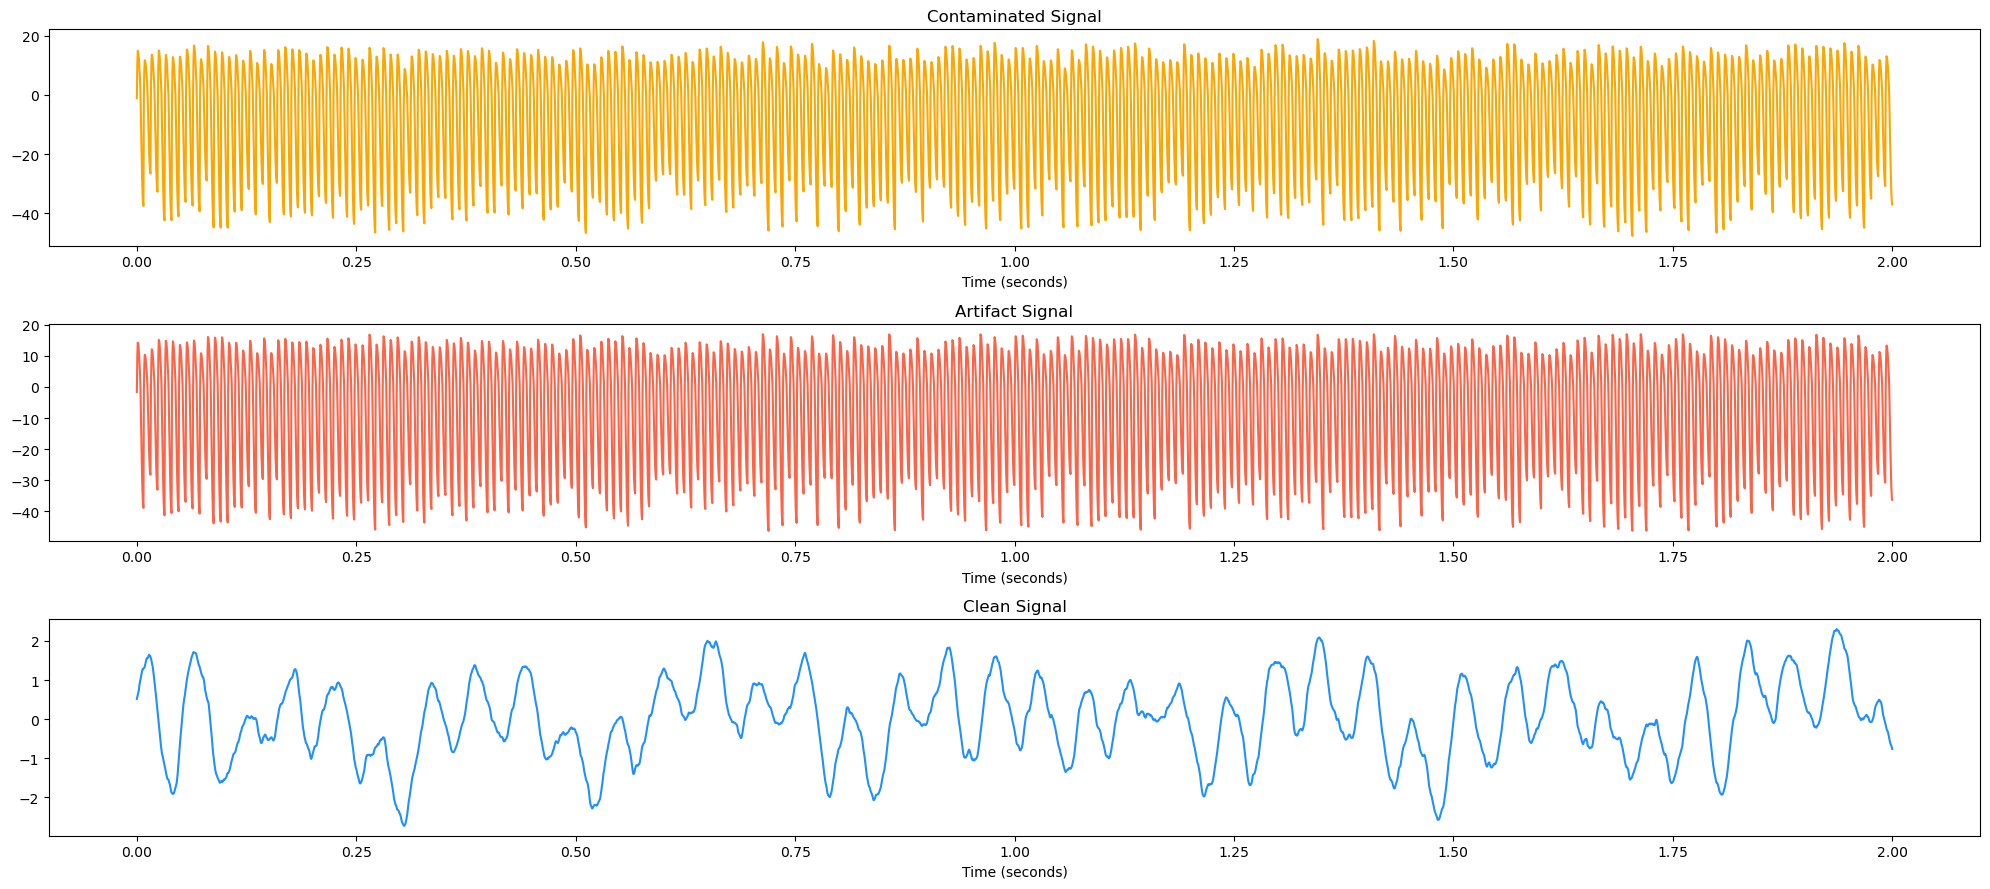

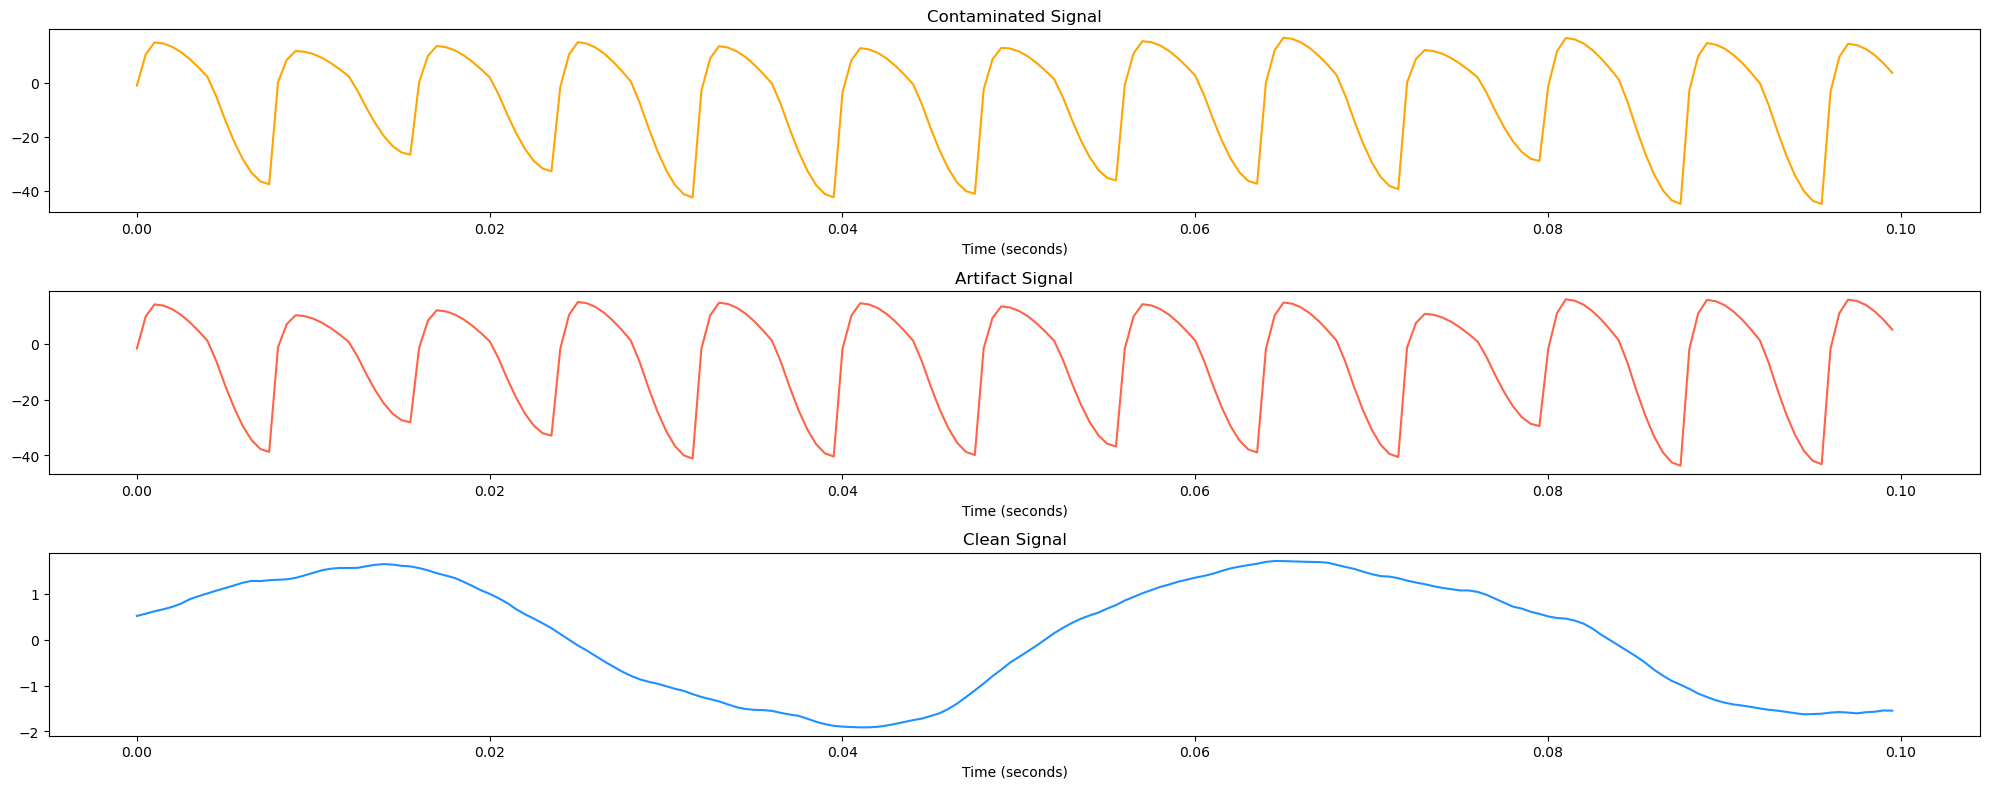

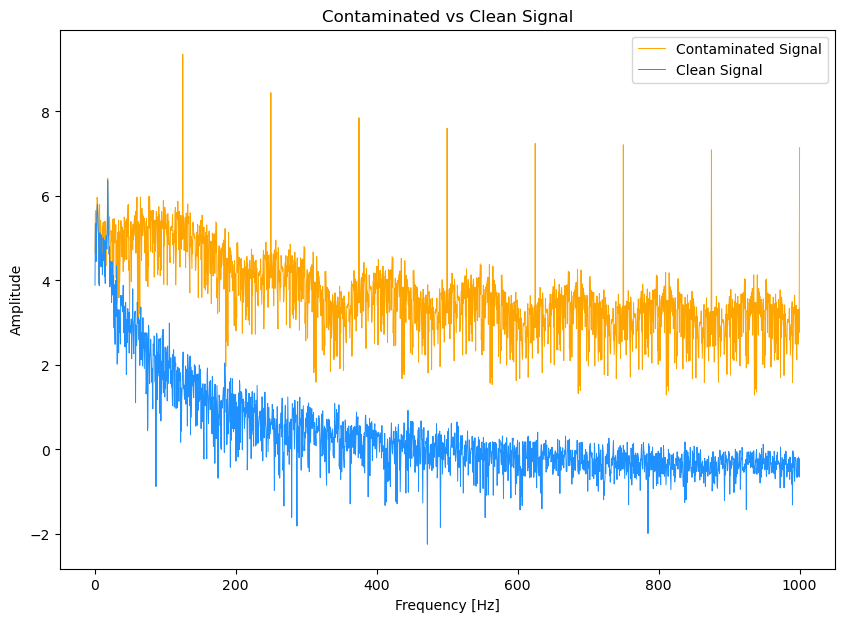

In [2]:
# 데이터 load & plot
datapath='../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [4]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [14]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000, 1)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000, 1)
-----------------------------


In [8]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class LSTM_time(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [10]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128 # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = LSTM_time(input_size, hidden_size, output_size, num_layers).to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTM_time(
  (dropout): Dropout(p=0.1, inplace=False)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [15]:
# 모델 학습
num_epochs = 200

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')

Epoch [1/200] | Loss: 0.03506266739219427
Epoch [2/200] | Loss: 0.003507503168657422
Epoch [3/200] | Loss: 0.0029405840579420327
Epoch [4/200] | Loss: 0.00287414507009089
Epoch [5/200] | Loss: 0.002789477426558733
Epoch [6/200] | Loss: 0.002530674785375595
Epoch [7/200] | Loss: 0.002303803265094757
Epoch [8/200] | Loss: 0.002075969171710312
Epoch [9/200] | Loss: 0.001698883124627173
Epoch [10/200] | Loss: 0.0012397914519533515
Epoch [11/200] | Loss: 0.0010933502297848464
Epoch [12/200] | Loss: 0.0010091500706039369
Epoch [13/200] | Loss: 0.0009468136494979263
Epoch [14/200] | Loss: 0.0008887666836380958
Epoch [15/200] | Loss: 0.0008304734551347792
Epoch [16/200] | Loss: 0.0008150648605078459
Epoch [17/200] | Loss: 0.0007409131596796215
Epoch [18/200] | Loss: 0.0006930728256702423
Epoch [19/200] | Loss: 0.0006622328888624907
Epoch [20/200] | Loss: 0.0006476047239266336
Epoch [21/200] | Loss: 0.000607931970153004
Epoch [22/200] | Loss: 0.0006048987130634487
Epoch [23/200] | Loss: 0.00053

In [ ]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

In [17]:
#학습함수 정의

def train_lstm(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTM_time(input_size = 1, 
                      hidden_size = config["hidden_size"], 
                      output_size = 1, 
                      num_layers = config["num_layers"]).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            epoch_loss = running_loss / len(train_loader.dataset)
            loss_list.append(epoch_loss)
        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')

        Contaminated = torch.tensor([])
        Clean = torch.tensor([])
        SACed = torch.tensor([])

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                
                y_pred = model(x)
                loss = criterion(y_pred, y)
                test_loss += loss.item() * x.size(0)

                Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
                SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
                Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

        tune.report(test_loss / len(test_loader.dataset))    

In [19]:
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

#hyperparameter tuning



# Set this to True for a smoke test that runs with a small synthetic dataset.
SMOKE_TEST = False

def main(num_samples=10, max_num_epochs=200, gpus_per_trial=2, smoke_test=False):
    config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "epochs": 200,
    "num_layers": tune.sample_from(lambda _: np.random.randint(1, 20)),
    "hidden_size" : tune.sample_from(lambda _: np.random.randint(2, 200))
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_lstm),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result, smoke_test=smoke_test)

main(num_samples=2, max_num_epochs=2, gpus_per_trial=0, smoke_test=SMOKE_TEST)

2024-08-07 07:47:33,483	ERROR tune_controller.py:1331 -- Trial task failed for trial train_lstm_d8779_00000
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch1\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\stell\anaconda3\envs\torch1\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\stell\anaconda3\envs\torch1\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\stell\anaconda3\envs\torch1\lib\site-packages\ray\_private\worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\stell\anaconda3\envs\torch1\lib\site-packages\ray\_private\worker.py", line 871, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeErro

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.